<a href="https://colab.research.google.com/github/lmoroney/tfbook/blob/master/chapter11/bidi-gru_timeseries-withdropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [22]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.9.1


In [24]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/station.csv \
    -O /tmp/station.csv

'wget' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。


In [25]:
def get_data():
    data_file = "station.csv"
    f = open(data_file)
    data = f.read()
    f.close()
    lines = data.split('\n')
    header = lines[0].split(',')
    lines = lines[1:]
    temperatures=[]
    for line in lines:
        if line:
            linedata = line.split(',')
            linedata = linedata[1:13]
            for item in linedata:
                if item:
                    temperatures.append(float(item))

    series = np.asarray(temperatures)
    time = np.arange(len(temperatures), dtype="float32")      
    return time, series


In [26]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


In [27]:
time, series = get_data()
mean = series.mean(axis=0)
series-=mean
std = series.std(axis=0)
series/=std
split_time = 780
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

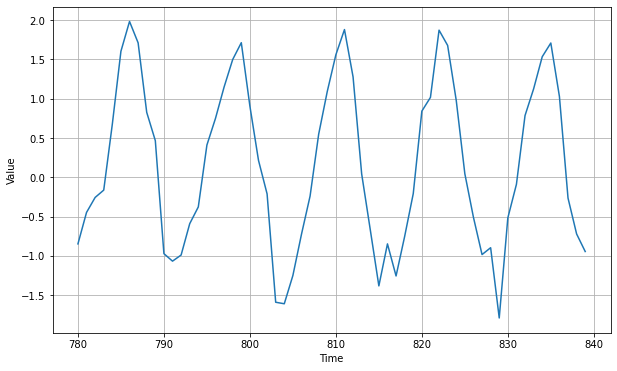

In [28]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [29]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [30]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
# Experiment with this to play with accuracy. Do note that
# this is a small dataset, so a large window size may
# cause errors.
window_size = 40
batch_size = 20
shuffle_buffer_size = 20

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True, dropout=0.1, recurrent_dropout=0.1)),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1)), 
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=500,  verbose=1, validation_data=valid_dataset)

Epoch 1/500


C:\Users\camjt\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


37/37 [==============================] - 11s 130ms/step - loss: 0.4500 - mae: 0.8595 - val_loss: 0.5288 - val_mae: 0.9583
Epoch 2/500
37/37 [==============================] - 4s 110ms/step - loss: 0.4471 - mae: 0.8557 - val_loss: 0.5266 - val_mae: 0.9560
Epoch 3/500
37/37 [==============================] - 4s 110ms/step - loss: 0.4452 - mae: 0.8532 - val_loss: 0.5245 - val_mae: 0.9538
Epoch 4/500
37/37 [==============================] - 5s 143ms/step - loss: 0.4431 - mae: 0.8513 - val_loss: 0.5223 - val_mae: 0.9515
Epoch 5/500
37/37 [==============================] - 5s 121ms/step - loss: 0.4403 - mae: 0.8479 - val_loss: 0.5201 - val_mae: 0.9492
Epoch 6/500
37/37 [==============================] - 4s 109ms/step - loss: 0.4386 - mae: 0.8458 - val_loss: 0.5179 - val_mae: 0.9470
Epoch 7/500
37/37 [==============================] - 4s 109ms/step - loss: 0.4381 - mae: 0.8448 - val_loss: 0.5158 - val_mae: 0.9447
Epoch 8/500
37/37 [==============================] - 4s 109ms/step - loss: 0.434

37/37 [==============================] - 4s 101ms/step - loss: 0.3321 - mae: 0.7192 - val_loss: 0.3966 - val_mae: 0.8212
Epoch 63/500
37/37 [==============================] - 4s 99ms/step - loss: 0.3310 - mae: 0.7172 - val_loss: 0.3944 - val_mae: 0.8187
Epoch 64/500
37/37 [==============================] - 4s 100ms/step - loss: 0.3270 - mae: 0.7130 - val_loss: 0.3921 - val_mae: 0.8161
Epoch 65/500
37/37 [==============================] - 4s 102ms/step - loss: 0.3256 - mae: 0.7106 - val_loss: 0.3899 - val_mae: 0.8135
Epoch 66/500
37/37 [==============================] - 4s 102ms/step - loss: 0.3217 - mae: 0.7057 - val_loss: 0.3877 - val_mae: 0.8109
Epoch 67/500
37/37 [==============================] - 4s 101ms/step - loss: 0.3204 - mae: 0.7043 - val_loss: 0.3854 - val_mae: 0.8082
Epoch 68/500
37/37 [==============================] - 4s 101ms/step - loss: 0.3203 - mae: 0.7045 - val_loss: 0.3832 - val_mae: 0.8056
Epoch 69/500
37/37 [==============================] - 4s 103ms/step - loss: 

37/37 [==============================] - 4s 99ms/step - loss: 0.2112 - mae: 0.5563 - val_loss: 0.2543 - val_mae: 0.6385
Epoch 124/500
37/37 [==============================] - 4s 100ms/step - loss: 0.2133 - mae: 0.5581 - val_loss: 0.2520 - val_mae: 0.6351
Epoch 125/500
37/37 [==============================] - 4s 101ms/step - loss: 0.2121 - mae: 0.5592 - val_loss: 0.2497 - val_mae: 0.6317
Epoch 126/500
37/37 [==============================] - 4s 101ms/step - loss: 0.2118 - mae: 0.5543 - val_loss: 0.2473 - val_mae: 0.6282
Epoch 127/500
37/37 [==============================] - 4s 99ms/step - loss: 0.2103 - mae: 0.5546 - val_loss: 0.2450 - val_mae: 0.6248
Epoch 128/500
37/37 [==============================] - 4s 99ms/step - loss: 0.2043 - mae: 0.5458 - val_loss: 0.2426 - val_mae: 0.6212
Epoch 129/500
37/37 [==============================] - 4s 99ms/step - loss: 0.2034 - mae: 0.5435 - val_loss: 0.2403 - val_mae: 0.6177
Epoch 130/500
37/37 [==============================] - 4s 99ms/step - los

Epoch 184/500
37/37 [==============================] - 4s 100ms/step - loss: 0.1220 - mae: 0.4068 - val_loss: 0.1307 - val_mae: 0.4256
Epoch 185/500
37/37 [==============================] - 4s 95ms/step - loss: 0.1183 - mae: 0.3947 - val_loss: 0.1292 - val_mae: 0.4224
Epoch 186/500
37/37 [==============================] - 3s 94ms/step - loss: 0.1191 - mae: 0.3978 - val_loss: 0.1277 - val_mae: 0.4192
Epoch 187/500
37/37 [==============================] - 4s 94ms/step - loss: 0.1214 - mae: 0.4032 - val_loss: 0.1261 - val_mae: 0.4159
Epoch 188/500
37/37 [==============================] - 4s 95ms/step - loss: 0.1170 - mae: 0.3911 - val_loss: 0.1245 - val_mae: 0.4127
Epoch 189/500
37/37 [==============================] - 4s 96ms/step - loss: 0.1141 - mae: 0.3909 - val_loss: 0.1230 - val_mae: 0.4094
Epoch 190/500
37/37 [==============================] - 4s 95ms/step - loss: 0.1128 - mae: 0.3859 - val_loss: 0.1215 - val_mae: 0.4063
Epoch 191/500
37/37 [==============================] - 4s 95m

Epoch 245/500
37/37 [==============================] - 5s 142ms/step - loss: 0.0755 - mae: 0.3036 - val_loss: 0.0691 - val_mae: 0.2790
Epoch 246/500
37/37 [==============================] - 4s 104ms/step - loss: 0.0734 - mae: 0.3028 - val_loss: 0.0686 - val_mae: 0.2777
Epoch 247/500
37/37 [==============================] - 4s 112ms/step - loss: 0.0715 - mae: 0.3021 - val_loss: 0.0680 - val_mae: 0.2761
Epoch 248/500
37/37 [==============================] - 5s 144ms/step - loss: 0.0749 - mae: 0.3032 - val_loss: 0.0675 - val_mae: 0.2747
Epoch 249/500
37/37 [==============================] - 4s 114ms/step - loss: 0.0704 - mae: 0.2983 - val_loss: 0.0670 - val_mae: 0.2735
Epoch 250/500
37/37 [==============================] - 5s 141ms/step - loss: 0.0737 - mae: 0.3056 - val_loss: 0.0665 - val_mae: 0.2722
Epoch 251/500
37/37 [==============================] - 5s 128ms/step - loss: 0.0771 - mae: 0.3079 - val_loss: 0.0661 - val_mae: 0.2710
Epoch 252/500
37/37 [==============================] - 

Epoch 306/500
37/37 [==============================] - 4s 99ms/step - loss: 0.0653 - mae: 0.2836 - val_loss: 0.0517 - val_mae: 0.2362
Epoch 307/500
37/37 [==============================] - 4s 108ms/step - loss: 0.0622 - mae: 0.2819 - val_loss: 0.0516 - val_mae: 0.2362
Epoch 308/500
37/37 [==============================] - 5s 129ms/step - loss: 0.0658 - mae: 0.2868 - val_loss: 0.0514 - val_mae: 0.2359
Epoch 309/500
37/37 [==============================] - 4s 99ms/step - loss: 0.0638 - mae: 0.2810 - val_loss: 0.0513 - val_mae: 0.2358
Epoch 310/500
37/37 [==============================] - 4s 100ms/step - loss: 0.0663 - mae: 0.2868 - val_loss: 0.0512 - val_mae: 0.2356
Epoch 311/500
37/37 [==============================] - 4s 96ms/step - loss: 0.0651 - mae: 0.2842 - val_loss: 0.0511 - val_mae: 0.2355
Epoch 312/500
37/37 [==============================] - 4s 96ms/step - loss: 0.0597 - mae: 0.2708 - val_loss: 0.0511 - val_mae: 0.2357
Epoch 313/500
37/37 [==============================] - 4s 9

Epoch 367/500
37/37 [==============================] - 4s 96ms/step - loss: 0.0611 - mae: 0.2775 - val_loss: 0.0478 - val_mae: 0.2335
Epoch 368/500
37/37 [==============================] - 4s 109ms/step - loss: 0.0606 - mae: 0.2748 - val_loss: 0.0478 - val_mae: 0.2337
Epoch 369/500
37/37 [==============================] - 4s 96ms/step - loss: 0.0639 - mae: 0.2855 - val_loss: 0.0477 - val_mae: 0.2335
Epoch 370/500
37/37 [==============================] - 4s 97ms/step - loss: 0.0638 - mae: 0.2842 - val_loss: 0.0477 - val_mae: 0.2332
Epoch 371/500
37/37 [==============================] - 5s 125ms/step - loss: 0.0647 - mae: 0.2836 - val_loss: 0.0477 - val_mae: 0.2333
Epoch 372/500
37/37 [==============================] - 5s 123ms/step - loss: 0.0653 - mae: 0.2854 - val_loss: 0.0477 - val_mae: 0.2331
Epoch 373/500
37/37 [==============================] - 5s 123ms/step - loss: 0.0597 - mae: 0.2763 - val_loss: 0.0476 - val_mae: 0.2330
Epoch 374/500
37/37 [==============================] - 5s 

Epoch 428/500
37/37 [==============================] - 5s 131ms/step - loss: 0.0652 - mae: 0.2844 - val_loss: 0.0471 - val_mae: 0.2337
Epoch 429/500
37/37 [==============================] - 6s 152ms/step - loss: 0.0631 - mae: 0.2797 - val_loss: 0.0472 - val_mae: 0.2339
Epoch 430/500
37/37 [==============================] - 6s 159ms/step - loss: 0.0639 - mae: 0.2795 - val_loss: 0.0472 - val_mae: 0.2340
Epoch 431/500
37/37 [==============================] - 4s 105ms/step - loss: 0.0562 - mae: 0.2698 - val_loss: 0.0472 - val_mae: 0.2344
Epoch 432/500
37/37 [==============================] - 4s 98ms/step - loss: 0.0647 - mae: 0.2864 - val_loss: 0.0472 - val_mae: 0.2345
Epoch 433/500
37/37 [==============================] - 4s 99ms/step - loss: 0.0603 - mae: 0.2713 - val_loss: 0.0472 - val_mae: 0.2344
Epoch 434/500
37/37 [==============================] - 4s 100ms/step - loss: 0.0623 - mae: 0.2793 - val_loss: 0.0472 - val_mae: 0.2344
Epoch 435/500
37/37 [==============================] - 4s

Epoch 489/500
37/37 [==============================] - 4s 95ms/step - loss: 0.0609 - mae: 0.2749 - val_loss: 0.0472 - val_mae: 0.2348
Epoch 490/500
37/37 [==============================] - 4s 101ms/step - loss: 0.0564 - mae: 0.2663 - val_loss: 0.0472 - val_mae: 0.2349
Epoch 491/500
37/37 [==============================] - 4s 99ms/step - loss: 0.0595 - mae: 0.2717 - val_loss: 0.0473 - val_mae: 0.2349
Epoch 492/500
37/37 [==============================] - 4s 98ms/step - loss: 0.0595 - mae: 0.2683 - val_loss: 0.0473 - val_mae: 0.2349
Epoch 493/500
37/37 [==============================] - 4s 99ms/step - loss: 0.0609 - mae: 0.2743 - val_loss: 0.0473 - val_mae: 0.2351
Epoch 494/500
37/37 [==============================] - 4s 100ms/step - loss: 0.0603 - mae: 0.2743 - val_loss: 0.0473 - val_mae: 0.2352
Epoch 495/500
37/37 [==============================] - 4s 100ms/step - loss: 0.0601 - mae: 0.2749 - val_loss: 0.0472 - val_mae: 0.2351
Epoch 496/500
37/37 [==============================] - 4s 1

In [31]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [32]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

2/2 [==============================] - 1s 44ms/step


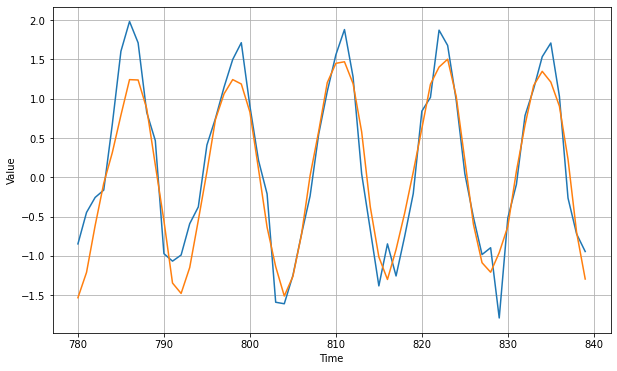

In [33]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()



In [34]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()
print(mae)

0.28704038


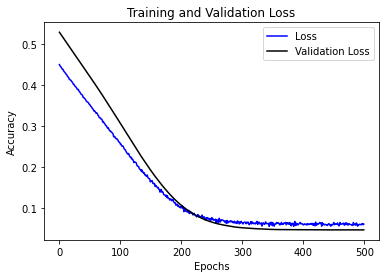

<Figure size 432x288 with 0 Axes>

In [35]:
mae=history.history['mae']
loss=history.history['loss']
val_mae=history.history['val_mae']
val_loss=history.history['val_loss']
epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
#plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
#plt.plot(epochs, val_mae, 'g')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()
